# Goal

This code estimates the time it takes to make large numbers of pyPI runs. I randomly draw N samples from the sample dataset and then calculate their associated potential intensities with the **pi.py** module and using "apply_ufunc" in xarray. These calculations were performed on laptop with a 3.1 GHz Intel Core processor.

The size of the sample data is important because pyPI calculations are profile dependant. There are 31 vertical levels in our sample dataset, and about 126,000 points. Running the whole dataset takes about 15 seconds.

# Setup

In [1]:
# import what we need
import sys
sys.path.append(sys.path[0]+'/..')
import numpy as np
import xarray as xr
import matplotlib
import matplotlib.pyplot as plt
import time
import random
# load PI calculation module
from tcpyPI import pi

In [2]:
# change default figure font settings
font = {'family' : 'sans-serif',
        'weight' : 1,
        'size'   : 16}

matplotlib.rc('font', **font)

# Load Data

In [3]:
# data location
dat_loc='../data/sample_data.nc'
# load= netcdf file
ds = xr.open_dataset(dat_loc)

In [4]:
ds

<xarray.Dataset>
Dimensions:  (lat: 73, lon: 144, month: 12, p: 31)
Coordinates:
  * p        (p) float64 1e+03 975.0 950.0 925.0 900.0 ... 40.0 30.0 20.0 10.0
  * lat      (lat) float64 90.0 87.5 85.0 82.5 80.0 ... -82.5 -85.0 -87.5 -90.0
  * lon      (lon) float64 -180.0 -177.5 -175.0 -172.5 ... 172.5 175.0 177.5
  * month    (month) float64 1.0 2.0 3.0 4.0 5.0 6.0 7.0 8.0 9.0 10.0 11.0 12.0
Data variables:
    lsm      (lat, lon) float64 ...
    sst      (month, lat, lon) float64 ...
    msl      (month, lat, lon) float64 ...
    t        (month, p, lat, lon) float64 ...
    q        (month, p, lat, lon) float64 ...
    Vmax     (month, lat, lon) float64 ...
    To       (month, lat, lon) float64 ...
    Pmin     (month, lat, lon) float64 ...
    LNB      (month, lat, lon) float64 ...
    PI_flag  (month, lat, lon) float64 ...

## Create Sample Datasets

Sample from the test data randomly to create data sets with a scaling number of points. From these we will test 10 times to capture the variability in the runtime.

In [5]:
# set the random seed
np.random.seed(16)

In [6]:
ngrid=ds.lat.size*ds.lon.size*ds.month.size
nlev=ds.p.size
print(ngrid,' ',nlev)

126144   31


In [7]:
# define the number of samples in each dataset
nsamps=np.arange(0,100)+1
nsamps=nsamps[::5]
ncube=nsamps**3
ncube

array([     1,    216,   1331,   4096,   9261,  17576,  29791,  46656,
        68921,  97336, 132651, 175616, 226981, 287496, 357911, 438976,
       531441, 636056, 753571, 884736])

## Time the Runs

In [8]:
# create the time elapsed array
nruns=10
time_elapsed=np.zeros((nruns,len(nsamps)),dtype='float32')
from xarray import apply_ufunc

time0=time.time()

for j in range(len(nsamps)):
    rlat,rlon,rmon=np.random.randint(0,ds.lat.size,nsamps[j]),np.random.randint(0,ds.lon.size,nsamps[j]),np.random.randint(0,ds.month.size,nsamps[j])
    ds0=ds.isel(lat=rlat,lon=rlon,month=rmon)
    
    for i in range(nruns):
        start_time = time.time()
        result = apply_ufunc(
            pi,
            ds0['sst'], ds0['msl'], ds0['p'], ds0['t'], ds0['q'],
            kwargs=dict(CKCD=0.9, ascent_flag=0, diss_flag=1, miss_handle=1),
            input_core_dims=[
                [], [], ['p', ], ['p', ], ['p', ],
            ],
            output_core_dims=[
                [], [], [], [], []
            ],
            vectorize=True
        )
        time_elapsed[i,j]=time.time()-start_time
        del result
    del rlat, rlon, rmon, ds0
    print(str(j)+'   Time Elapsed='+str(time.time()-time0))

0   Time Elapsed=3.7192490100860596
1   Time Elapsed=5.793249845504761
2   Time Elapsed=9.140596151351929
3   Time Elapsed=20.804136991500854
4   Time Elapsed=42.195549964904785
5   Time Elapsed=83.61440587043762
6   Time Elapsed=114.07612872123718
7   Time Elapsed=197.2674698829651
8   Time Elapsed=278.9141421318054
9   Time Elapsed=390.67475390434265
10   Time Elapsed=540.4342930316925
11   Time Elapsed=755.1462428569794
12   Time Elapsed=1037.4361078739166
13   Time Elapsed=1446.1667609214783
14   Time Elapsed=1881.5437519550323
15   Time Elapsed=2250.4643280506134
16   Time Elapsed=2846.8729298114777
17   Time Elapsed=3551.042883872986
18   Time Elapsed=4295.858358860016
19   Time Elapsed=5184.055063962936


In [9]:
# fit a curve
z = np.polyfit(ncube,np.mean(time_elapsed,axis=0), 1)
p = np.poly1d(z)
x = np.linspace(0, 1e6, 1000)

In [10]:
print('R-squared is '+str(np.ma.corrcoef(ncube,np.mean(time_elapsed,axis=0))[0,1]**2))

R-squared is 0.9802794696381533


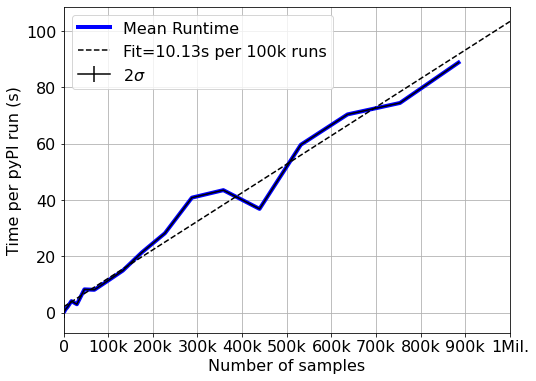

In [11]:
plt.figure(figsize=(8,6))
plt.errorbar(ncube,np.mean(time_elapsed,axis=0), yerr=2*np.std(time_elapsed,axis=0),color='k',label='2$\sigma$')
plt.plot(ncube,np.mean(time_elapsed,axis=0),'b',lw=4,label='Mean Runtime')
plt.plot(x,p(x),'--k',label='Fit='+str(round(z[0]*100000,2))+'s per 100k runs')
plt.ylabel('Time per pyPI run (s)')
plt.xlabel('Number of samples')
plt.grid()
plt.xticks(np.arange(0,1e6+1,1e5),labels=['0','100k','200k','300k','400k','500k','600k','700k','800k','900k','1Mil.'])
plt.xlim([0,1e6])
plt.legend()
plt.show()